<a href="https://colab.research.google.com/github/andrewKv/FaceProj/blob/main/projTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Masked Image Classifier


### Installs and setup

In [1]:
pip install fastai

In [2]:
!pip install -Uqq fastbook

     |████████████████████████████████| 727kB 8.6MB/s 
     |████████████████████████████████| 1.2MB 16.7MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 194kB 34.3MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 61kB 6.1MB/s 
     |████████████████████████████████| 776.8MB 22kB/s 
     |████████████████████████████████| 12.8MB 38.4MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.


In [3]:
#import fastbook
#import fastai
#fastbook.setup_book()
#from fastbook import *
#from fastai.vision.widgets import *


In [4]:
#hide
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [5]:
#hide
from fastbook import *
from fastai.vision.widgets import *
from fastai.vision import *

In [6]:
from nbdev.showdoc import *

In [7]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [8]:
root_dir="/content/gdrive/MyDrive/Final year/Project/Colab Notebooks/"
base_dir=root_dir+'PictureDataset/'

In [9]:
bs=16

### Create directory and folders


Combining images into one folder. Each folder represents a category


In [10]:
path=Path(root_dir+'PictureDataset/NameFolder')

In [ ]:
for image in path.ls():
  filename = str(image).split('/')[-1]
  dest = (basePath/filename)
  dest.mkdir(exist_ok=True)

In [ ]:
for folder in basePath.ls():
  for image in path.ls():
    filename = str(image).split('/')[-1].replace("_Mask.jpg","")
    if filename == str(folder).split('/')[-1].replace(".png",""):
      image = image.rename(folder/filename)

In [ ]:
for folder in path.ls():
  for image in folder.ls():
    filename = str(image).split('/')[-1]
    if not (".png" in filename):
      image = image.rename(folder/(filename+".png"))

## View data

### Data Augmentation


In [ ]:
images = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter = GrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(128))

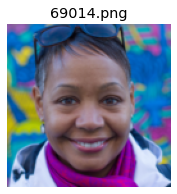

In [ ]:
dls = images.dataloaders(path)
dls.valid.show_batch(max_n=1, nrows=1)

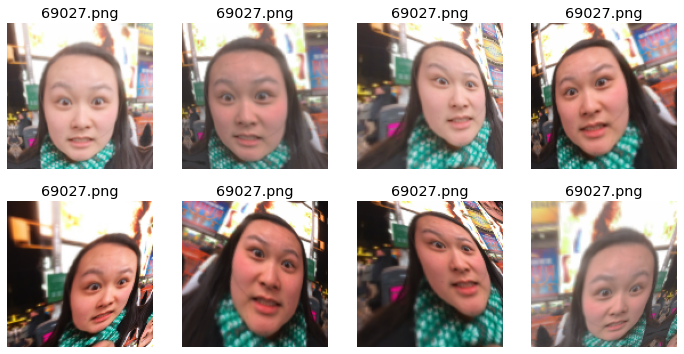

In [ ]:
images = images.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = images.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Nearest Neighbours approach


### Dataset Creation


In [11]:
import PIL
import torch
import numpy as np

In [12]:
train_path=Path(root_dir+'PictureDataset/NameFolder/train')
valid_path = Path(root_dir+'PictureDataset/NameFolder/valid')
items = get_image_files(Path(root_dir+'PictureDataset/NameFolder'))

In [13]:
train_items = get_image_files(train_path)
valid_items = get_image_files(valid_path)
split_idx = RandomSplitter()(train_items)

In [14]:
def open_image(fname, size=224):
    img = PIL.Image.open(fname).convert('RGB')
    img = img.resize((size, size))
    t = torch.Tensor(np.array(img))
    return t.permute(2,0,1).float()/255.0

In [15]:
labels = list(set(train_items.map(parent_label)))
lbl2files = {l: [f for f in items if parent_label(f) == l] for l in labels}
len(labels)

970

In [16]:
#lbl2files

In [17]:
class SiameseDataset(torch.utils.data.Dataset):
    def __init__(self, files, is_valid=False):
        self.files,self.is_valid = files,is_valid
        if is_valid: self.files2 = [self._draw(f) for f in files]
        
    def __getitem__(self, i):
        file1 = self.files[i]
        (file2,same) = self.files2[i] if self.is_valid else self._draw(file1)
        img1,img2 = open_image(file1),open_image(file2)
        return (img1, img2, torch.Tensor([same]).squeeze())
    
    def __len__(self): return len(self.files)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = parent_label(f)
        if not same: cls = random.choice([l for l in labels if l != cls]) 
        return random.choice(lbl2files[cls]),same

### Showing similar images

In [18]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        if len(self) > 2:
            img1,img2,similarity = self
        else:
            img1,img2 = self
            similarity = 'Undetermined'
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), title=similarity, ctx=ctx, **kwargs)

In [19]:
@typedispatch
def show_batch(x:SiameseImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): SiameseImage(x[0][i], x[1][i], ['Not similar','Similar'][x[2][i].item()]).show(ctx=ctx)

@typedispatch
def show_results(x:SiameseImage, y, samples, outs, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        title = f'Actual: {["Not similar","Similar"][x[2][i].item()]} \n Prediction: {["Not similar","Similar"][y[2][i].item()]}'
        SiameseImage(x[0][i], x[1][i], title).show(ctx=ctx)

### Predictions

In [20]:
@patch
def siampredict(self:Learner, item, rm_type_tfms=None, with_input=False):
    res = self.predict(item, rm_type_tfms=None, with_input=False)
    if res[0] == tensor(0):
        SiameseImage(item[0], item[1], 'Prediction: Not similar').show()
    else:
        SiameseImage(item[0], item[1], 'Prediction: Similar').show()
    return res

In [21]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

In [22]:
encoder = create_body(resnet34, cut=-2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [23]:
head = create_head(1024, 2, ps=0.5)
model = SiameseModel(encoder, head)

In [24]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

In [25]:
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

In [26]:
class SiameseTransform(Transform):
    def __init__(self, files, splits):
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2,t = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, int(t))
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = parent_label(f)
        if not same: cls = random.choice(L(l for l in labels if l != cls)) 
        return random.choice(lbl2files[cls]),same

In [ ]:
splits = RandomSplitter()(train_items)
tfm = SiameseTransform(train_items, splits)
tls = TfmdLists(train_items, tfm, splits=splits)
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [ ]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), splitter=siamese_splitter, metrics=accuracy)

In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(4, 4e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.399111,302.406067,0.608579,29:55
1,0.426105,1.020445,0.852547,30:01
2,0.397423,0.251021,0.908847,30:16
3,0.337539,0.257544,0.898123,30:11


In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(4, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.402140,0.308721,0.884718,29:51
1,0.392276,0.290392,0.908847,29:26
2,0.370697,0.277745,0.919571,29:14
3,0.369804,0.278796,0.916890,29:57


In [ ]:
learn.path = Path('/content/gdrive/MyDrive/Final year/Project/Colab Notebooks/PictureDataset')

In [ ]:
learn.save("trained_model")

In [ ]:
learn2.show_results()

## Custom Upload

In [27]:
pickle_path = Path(root_dir+'PictureDataset/models/export.pkl')

In [28]:
picklelearner = load_learner(pickle_path)

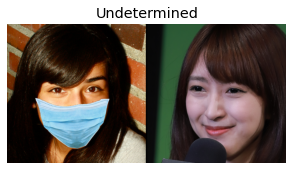

In [29]:
imgtest = PILImage.create(items[2])
imgval = PILImage.create(items[103])
siamtest = SiameseImage(imgval, imgtest)
siamtest.show();

(tensor(0), tensor(0), tensor([0.9920, 0.0080]))

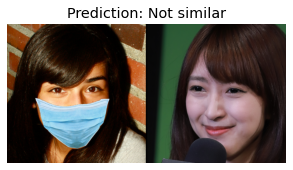

In [30]:
picklelearner.siampredict(siamtest)

In [31]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila

     |████████████████████████████████| 2.5MB 8.4MB/s 
     |████████████████████████████████| 378kB 46.2MB/s 
     |████████████████████████████████| 552kB 50.2MB/s 
     |████████████████████████████████| 122kB 42.9MB/s 
     |████████████████████████████████| 71kB 6.7MB/s 
     |████████████████████████████████| 430kB 36.3MB/s 
ERROR: nbdev 1.1.14 has requirement nbconvert<6, but you'll have nbconvert 6.0.7 which is incompatible.
ERROR: google-colab 1.0.0 has requirement tornado~=5.1.0; python_version >= "3.0", but you'll have tornado 6.1 which is incompatible.
  Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
  Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5


Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?


## Train model

In [ ]:
learn = cnn_learner(dls, resnet18,n_out=labels, metrics=error_rate)
learn.fine_tune(3)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
#interp.plot_confusion_matrix()

AttributeError: ignored

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
learn.lr_find()
learn.recorder.plot()

## Interpretation and data cleaning

We can see the least accurate classifications

In [ ]:
interp.plot_top_losses(5, nrows=1)

And clean the generated model

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

## Running on custom image upload

In [ ]:
learn.export()

In [ ]:
learn.path = pickle_path

In [ ]:
pickle_path = Path('/content/gdrive/MyDrive/Final year/Project/Colab Notebooks/PictureDataset/models/export.pkl')


In [ ]:
path.ls(file_exts='.pkl')

(#1) [Path('/content/gdrive/MyDrive/Final year/Project/Colab Notebooks/PictureDataset/NameFolder/export.pkl')]

In [ ]:
from fastai.vision.all import *
from fastai.vision.widgets import *
learn_inf = load_learner(path/'export.pkl', cpu=True)
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()

In [ ]:
def on_data_change(change):
    lbl_pred.value = ''
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

In [ ]:
btn_upload.observe(on_data_change, names=['data'])

In [ ]:
display(widgets.VBox([widgets.Label('Image upload'), btn_upload, out_pl, lbl_pred]))